In [1]:
import numpy as np
import toml
import time
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}


[557 766]
27.85 38.300000000000004


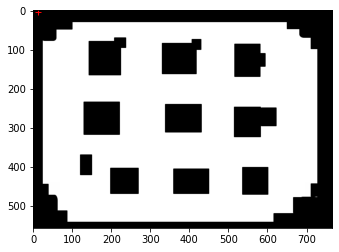

In [19]:
grid_res = 0.05
image = Image.open('./circuit.png').convert('LA') # open the test circuit
grid_data = np.asarray(image)[:,:,0]/255


#find the shape
grid_shape = np.array(grid_data.shape)
print(grid_shape)
#find the real-world extents of the grid: opposite vertices of the rectangle
x1, y1 = 0, 0
#use shape and grid_res to calculate the top-right vertex
x2, y2 =  grid_shape*grid_res
print(x2, y2)
#display the image using imshow()
#pay attention to the keywords origin, cmap and extent
#Default origin is top-left, but we should use 'lower'
#how should grid_data be transformed
plt.figure()

#complete
plt.imshow(grid_data, cmap = plt.cm.gray)
start_pose = np.array([12, 4, np.pi/2])
plt.plot(start_pose[0], start_pose[1],'r+')
plt.show()

In [5]:
def euclidean(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

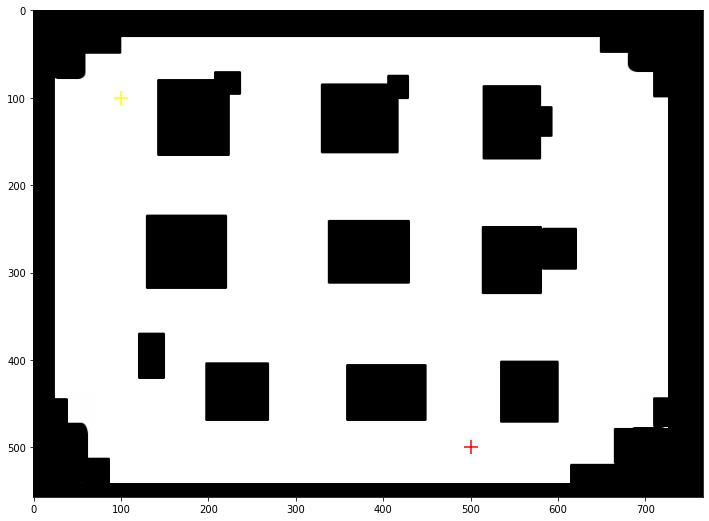

In [6]:
start = (100, 100)
goal = (500, 500)

# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.gray)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
plt.show()

In [7]:
#initialize graph
print(grid_shape)
G = nx.grid_2d_graph(grid_shape[0], grid_shape[1])
print(grid_data)
num_nodes = 0 # counter to keep track of deleted nodes
#loop to remove nodes
for i in range(grid_shape[0]): 
  for j in range(grid_shape[1]):
    if grid_data[i, j] == 0:
      G.remove_node((i, j))
      num_nodes +=1
print(f"removed {num_nodes} nodes")
print(G)

[557 766]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
removed 144629 nodes



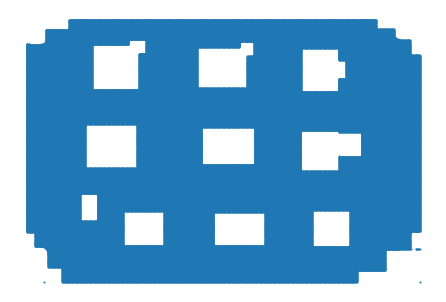

In [8]:
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos, node_size=1) 


In [9]:
#ost = np.ones(grid_size)
nx.set_edge_attributes(G,{e:1 for e in G.edges()}, "cost")
astar_path = nx.astar_path(G, start, goal, heuristic=euclidean, weight='cost')

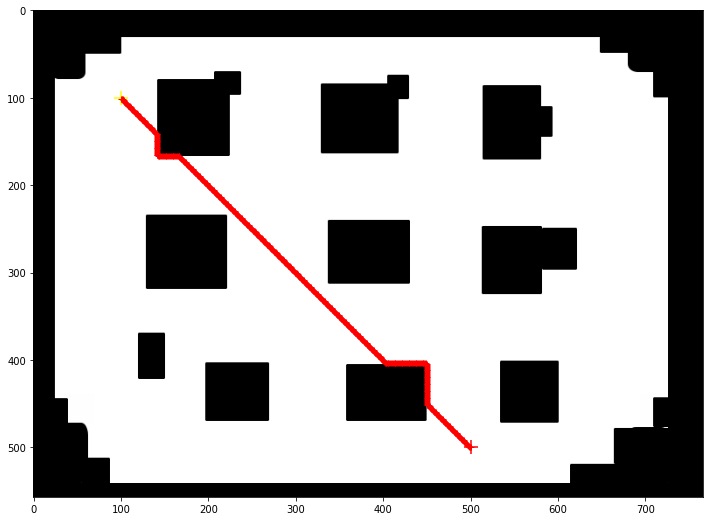

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.gray)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')

In [11]:
print(astar_path)

[(100, 100), (101, 100), (101, 101), (102, 101), (102, 102), (103, 102), (103, 103), (104, 103), (104, 104), (105, 104), (105, 105), (106, 105), (106, 106), (107, 106), (107, 107), (108, 107), (108, 108), (109, 108), (109, 109), (110, 109), (110, 110), (111, 110), (111, 111), (112, 111), (112, 112), (113, 112), (113, 113), (114, 113), (114, 114), (115, 114), (115, 115), (116, 115), (116, 116), (117, 116), (117, 117), (118, 117), (118, 118), (119, 118), (119, 119), (120, 119), (120, 120), (121, 120), (121, 121), (122, 121), (122, 122), (123, 122), (123, 123), (124, 123), (124, 124), (125, 124), (125, 125), (126, 125), (126, 126), (127, 126), (127, 127), (128, 127), (128, 128), (129, 128), (129, 129), (130, 129), (130, 130), (131, 130), (131, 131), (132, 131), (132, 132), (133, 132), (133, 133), (134, 133), (134, 134), (135, 134), (135, 135), (136, 135), (136, 136), (137, 136), (137, 137), (138, 137), (138, 138), (139, 138), (139, 139), (140, 139), (140, 140), (141, 140), (141, 141), (14

In [12]:
grid_res = 0.05
def circle_collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    r = 1
    l = 1
    circles = [(0, 0, r), (0, l, r), (0, -l, r)]
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],[np.cos(tl), np.sin(tl)]])
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot), int(yc_rot)
        rc_pix = (rc)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)
        occupied_pt = grid[X, Y] == 0
        if np.sum(np.multiply(inside_circle, occupied_pt)):
          return True
    return False

In [13]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])   
    return poses

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with acc =  ACC_MAX, provided returned velocity < V_MAX, otherwise returns V_MAX
    v_min = max(0, v - ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with deacc =  ACC_MAX, provided returned velocity > 0, otherwise returns 0

    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=21)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])   # Cartesian product
    
    #calculate kappa for the set of commands  (w/v)
    epsilon = 1e-6
    #       (   w_values  ) / (     v_values + epsilon)
    kappa = (commands[:,1]) / (commands[:,0] + epsilon)  
    # epsilon is added to get rid of zero error, ie when v = 0, w/v is undefined 
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose, v, w, pred_horizon)   # Number of steps = prediction horizon
        final_x, final_y = local_path[-1][0], local_path[-1][1]   # Get last position
        # Ignore collision check for now
        # if circle_collision_check(grid, local_path): #ignore colliding paths
        #     print("local path has a collision")
        #     continue
        
        # calculate cross-track error
        # can use a simplistic definition of how close is the last pose in local path from the ref path
        cte = np.inf

        # Calculate distance between final ref_path point and final local_path point
        cte = np.sqrt((ref_path[-1][0]-local_path[-1][0])**2 + (ref_path[-1][1]-local_path[-1][1])**2)
        # other cost functions are possible
        # can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, [v, w]

    if best_command:
        return best_command
    else:
        return [0, 0]

In [14]:
# start_pose = np.array([0, 0, np.pi/2])
start_pose = [100, 100, np.pi/2]
#route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = astar_path
print(len(ref_path))
pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path) - 1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # print(np.round(local_ref_path,3))
    curr_x, curr_y = pose[0], pose[1]
    local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
    # update path_index using current pose and local_ref_path
    if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*100:
      path_index = path_index + 1

    # get next command
    v, w = track(local_ref_path, pose, v, w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(tuple(pose), v, w)
    pose = pose[0]
    # print(np.round(pose,3))
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")
# print(pose)

801
idx:0, v:0.050, w:-0.300, time:12.3ms
idx:0, v:0.100, w:-0.600, time:21.7ms
idx:0, v:0.150, w:-0.900, time:24.9ms
idx:0, v:0.200, w:-1.000, time:22.7ms
idx:0, v:0.250, w:-0.985, time:23.2ms
idx:0, v:0.300, w:-0.843, time:23.2ms
idx:0, v:0.350, w:-0.703, time:22.7ms
idx:0, v:0.400, w:-0.612, time:23.0ms
idx:0, v:0.450, w:-0.522, time:22.9ms
idx:0, v:0.500, w:-0.432, time:31.0ms
idx:0, v:0.550, w:-0.372, time:25.1ms
idx:0, v:0.600, w:-0.312, time:27.1ms
idx:0, v:0.650, w:-0.252, time:24.6ms
idx:0, v:0.700, w:-0.222, time:22.5ms
idx:0, v:0.750, w:-0.192, time:23.3ms
idx:0, v:0.800, w:-0.162, time:22.4ms
idx:0, v:0.850, w:-0.132, time:25.3ms
idx:0, v:0.900, w:-0.132, time:21.6ms
idx:0, v:0.950, w:-0.102, time:26.0ms
idx:0, v:1.000, w:-0.102, time:22.4ms
idx:0, v:1.050, w:-0.072, time:22.0ms
idx:0, v:1.100, w:-0.072, time:22.4ms
idx:0, v:1.150, w:-0.042, time:22.2ms
idx:0, v:1.200, w:-0.042, time:22.4ms
idx:1, v:1.200, w:-0.042, time:28.7ms
idx:1, v:1.200, w:0.228, time:21.9ms
idx:1, v:

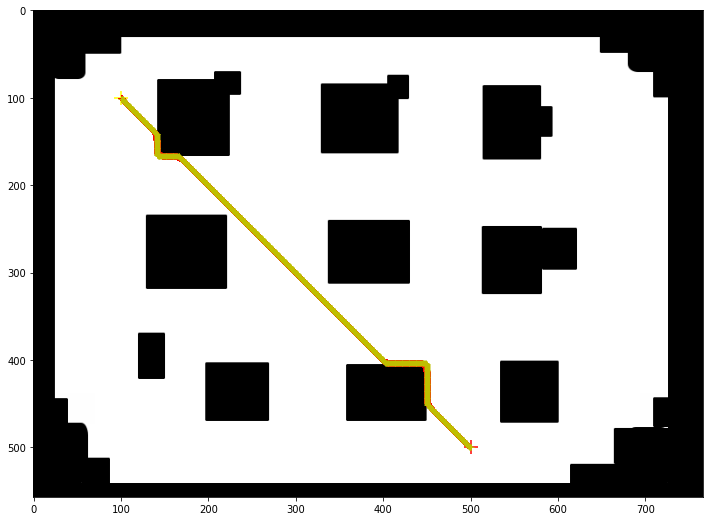

In [20]:
poses = np.array(logs)[:,:3]
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.gray)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
ax.plot(poses[:,1], poses[:,0],'r+')
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'y+')


In [21]:
obstacles = np.array([[335, 370, 300, 350]]) 

for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 0.0

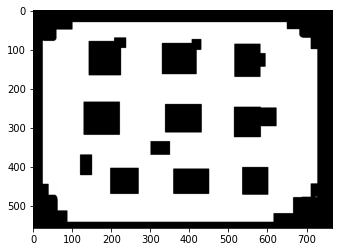

In [22]:
plt.figure()
plt.imshow(grid_data, cmap=plt.cm.gray )

In [23]:
class Lidar(object):
    def __init__(self, nbeams=5, fov=60, max_dist=5.0, sampling_pts=20):
        #nbeams = number of sensing beams
        #FOV = field-of-view of Lidar/ coverage in degrees
        #max_dist = maximum distance Lidar can sense
        #sampling_pts = num pts on a given beam for obstacle check
        self.beam_angles = np.deg2rad(np.linspace(-fov/2+np.pi/2,fov/2+np.pi/2,num=nbeams))
        #print(self.beam_angles)
        self.line_sampler = max_dist * np.linspace(0, 1, num=sampling_pts)
    
    def set_env(self, grid, grid_res=0.05):
        #2-D occupancy grid and grid_resolution
        self.grid = grid
        #print(grid)
        self.grid_res = grid_res
    
    def sense_obstacles(self, pose):
        xc, yc, theta = pose
        beam_data = []
        for b in self.beam_angles:
            direction = np.array([np.sin(theta+b), np.cos(theta+b)])
            for d in self.line_sampler:
                beam_x, beam_y = np.array([xc, yc]) + d*direction
                i, j = int(beam_x), int(beam_y)
                #print(self.grid[i][j])
                if self.grid[i][j] == 0:
                    break
            beam_data.append(d)
        #print(beam_data)
        return beam_data

In [24]:
curr_pose = [200, 200, np.pi/2]
lidar = Lidar(max_dist=10.0)
lidar.set_env(grid_data)
dist = lidar.sense_obstacles(pose=curr_pose)
print(f"Beam distances are {dist}")

Beam distances are [10.0, 10.0, 10.0, 10.0, 10.0]


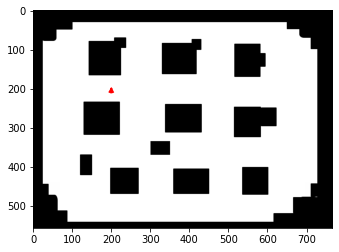

In [25]:
#calculate the extents    
plt.figure()
plt.imshow(grid_data, cmap=plt.cm.gray )
x, y, theta = curr_pose
for b, tprime in zip(dist, lidar.beam_angles):
    t = tprime+theta
    plt.plot((x, x+b*np.cos(t)),(y, y+b*np.sin(t)),'r-')

In [26]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])   
    return poses

def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with acc =  ACC_MAX, provided returned velocity < V_MAX, otherwise returns V_MAX
    v_min = max(0, v - ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with deacc =  ACC_MAX, provided returned velocity > 0, otherwise returns 0

    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    ws = np.linspace(w_min, w_max, num=21)
    
    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])   # Cartesian product
    
    #calculate kappa for the set of commands  (w/v)
    epsilon = 1e-6
    #       (   w_values  ) / (     v_values + epsilon)
    kappa = (commands[:,1]) / (commands[:,0] + epsilon)  
    # epsilon is added to get rid of zero error, ie when v = 0, w/v is undefined 
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    #initialize path cost
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        local_path = simulate_unicycle(pose, v, w, pred_horizon)   # Number of steps = prediction horizon
        final_x, final_y = local_path[-1][0], local_path[-1][1]   # Get last position
        # Ignore collision check for now
        
        curr_pose = [final_x, final_y, np.pi/2]
        lidar = Lidar(max_dist=10.0)
        lidar.set_env(grid_data)
        dist = lidar.sense_obstacles(pose=curr_pose)
        if any([x<5 for x in dist]):
          print('local path has a collision')
          continue 

        #if circle_collision_check(grid_data, local_path): #ignore colliding paths
         #    print("local path has a collision")
          #   continue
        
        # calculate cross-track error
        # can use a simplistic definition of how close is the last pose in local path from the ref path
        cte = np.inf

        # Calculate distance between final ref_path point and final local_path point
        cte = np.sqrt((ref_path[-1][0]-local_path[-1][0])**2 + (ref_path[-1][1]-local_path[-1][1])**2)
        # other cost functions are possible
        # can modify collision checker to give distance to closest obstacle
        cost = w_cte*cte + w_speed*(V_MAX - v)**2 
        
        #check if there is a better candidate
        if cost < best_cost:
            best_cost, best_command = cost, [v, w]

    if best_command:
        print(best_command)
        return best_command
    else:
        return [0, 0]

In [ ]:

# There seems to be a problem in this that I'm trying to figure out, the code does avoid obstacles but it keeps going around the obstacle 
start_pose = [100, 100, np.pi/2]
ref_path = astar_path
print(len(ref_path))
pose = start_pose
logs = []
path_index = 0
v, w = 0.0, 0.0
while path_index < len(ref_path) - 1:
    t0 = time.time()
    local_ref_path = ref_path[path_index:path_index+pred_horizon]
    # print(np.round(local_ref_path,3))
    curr_x, curr_y = pose[0], pose[1]
    local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
    # update path_index using current pose and local_ref_path
    if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*100:
      path_index = path_index + 1

    # get next command
    v, w = track(local_ref_path, pose, v, w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(tuple(pose), v, w)
    pose = pose[0]
    # print(np.round(pose,3))
    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms")
# print(pose)

Streaming output truncated to the last 5000 lines.
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
local path has a collision
loca

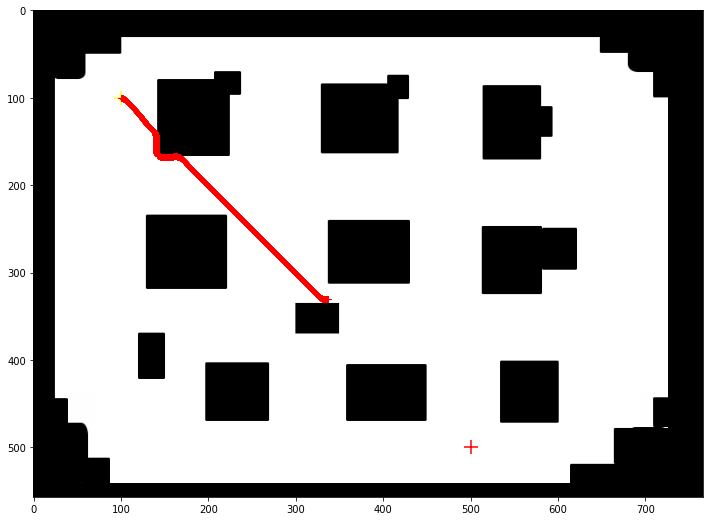

In [ ]:

poses = np.array(logs)[:,:3]
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid_data, cmap=plt.cm.gray)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
ax.plot(poses[:,1], poses[:,0],'r+')
